# Exploratory Data Analysis 
***
This notebook is a guide to understanding the preprocessing steps taken to prepare the data for model training.

Before performing any data analysis, the raw data is processed through a pipeline based on domain knowledge to make it suitable for analysis. The parsed CSV files are filtered, cleaned and converted to 'parquet' file formats which is better suited for large datasets and complex queries.

### Import necessary libraries 

In [4]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd
import time

### Define path to data directory

In [5]:
data_dir = 'D:\\anticheat\\data\\preprocessed_data'

### Data Selection

As the number of '*normal*' instances far outnumber the '*abnormal*' or '*anomalous*' instances, we will ignore all files which contain no anomalies. Another reason to ignore these files is the absence of any correlation between the features and the target. However, with sufficient compute power and time to train, this data can be used to better train the model to '*normal*' instances.  

In [18]:
st = time.time()
data = []
for f in os.listdir(data_dir):
    df = dd.read_parquet(os.path.join(data_dir, f))
    if len(df['label'].unique()) == 1: 
        continue
    else:
        data.append(df)

df = dd.concat(data)
print(df.compute().shape)
print(f"Time taken to read files:", time.time() - st,"seconds")

(2276865, 97)
Time taken to read files: 62.164588928222656 seconds


In [19]:
st = time.time()
data = []
for f in os.listdir(data_dir):
    df = pd.read_parquet(os.path.join(data_dir, f))
    if len(df['label'].unique()) == 1:
        continue
    else:
        data.append(df)

df = pd.concat(data)
print(df.shape)
print(f"Time taken to read files:", time.time() - st,"seconds")
df.reset_index(drop=True, inplace=True)

(2276865, 97)
Time taken to read files: 14.34180235862732 seconds


Even after data selection, we have over 2 million instances with mixed labels. We use the Dask library to utilize our machine's parallel processing capabilites. As seen above on calling `df.shape`, Dask does not actually load the data into memory, but instead returns a **'Delayed'** object. Dask dataframes are *lazy* by nature, until the `compute()` method is called. However, the data has already been converted to "parquet" format, which is 4-10x faster to read and write when compared to formats like CSV. As can be seen above, Pandas can read this cleaner data faster than Dask.

### Class Imbalance

Even after selecting only the required data files, there is a big imbalance in the target classes. Class imbalance can be a tricky issue, but there are several strategies that can address it. Some of them are:

1. Resampling: Oversampling or undersampling the minority or majority class can balance the class distribution. However, excessive oversampling of the minor class for our dataset would cause overfitting during training due a large amount of duplicated instances. SMOTE is an algorithm that creates synthetic instances by using interpolation between existing minority classes, but due to the extremely sensitive nature of our data, synthetic generation cannot be used. Undersampling the majority class is a viable option for our case.

2. Some algorithms allow us to assign different weights to classes. Since we are using state-of-the-art models, we aim not to modify the training processes of these models, but instead making the data suitable for processing.

3. Appropriate evaluation metrics can be used when dealing with imbalanced datasets.

In [20]:
df['label'].value_counts()

label
0.0    2021792
1.0     255073
Name: count, dtype: int64

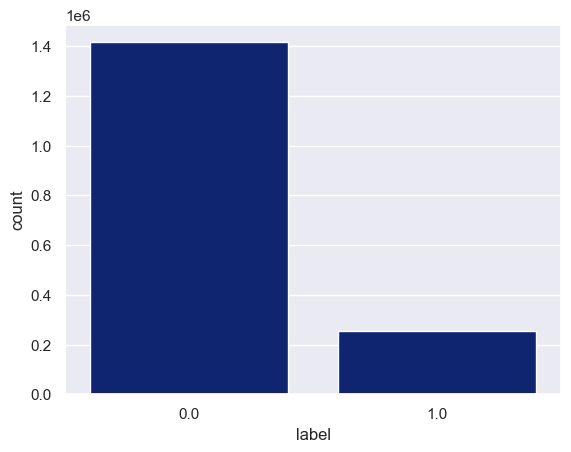

In [22]:
sns.set(style='darkgrid', palette='dark')
sns.countplot(x = df['label'])
plt.savefig('./figures/class_distribution')
plt.show()

The anomalous instances are severely outnumbered even after selectively choosing our data. However, the aim is to train a model that can successfully detect anomalies, which by nature are rarer than *'normal'* instances. Hence we will keep our distribution as is, where the *'outliers'* form about 10% of our entire dataset. 

# Correlated Features

Removing highly correlated features from a dataset before training a machine learning model is often done to improve the model's performance and interpretability.

1. Redundancy: Highly correlated features provide essentially the same information to the model, making it redundant.

2. Model performance: Correlated features can lead to multicollinearity, which can destabilize linear models (e.g., linear regression) and make it challenging for them to estimate the individual contributions of each feature accurately.

3. Efficiency: Training a model with fewer features, especially when working with large datasets, can significantly reduce the computational resources and time required for training.

4. Improved generalization: Removing correlated features can help the model generalize better to unseen data by reducing the noise introduced by the correlated features.

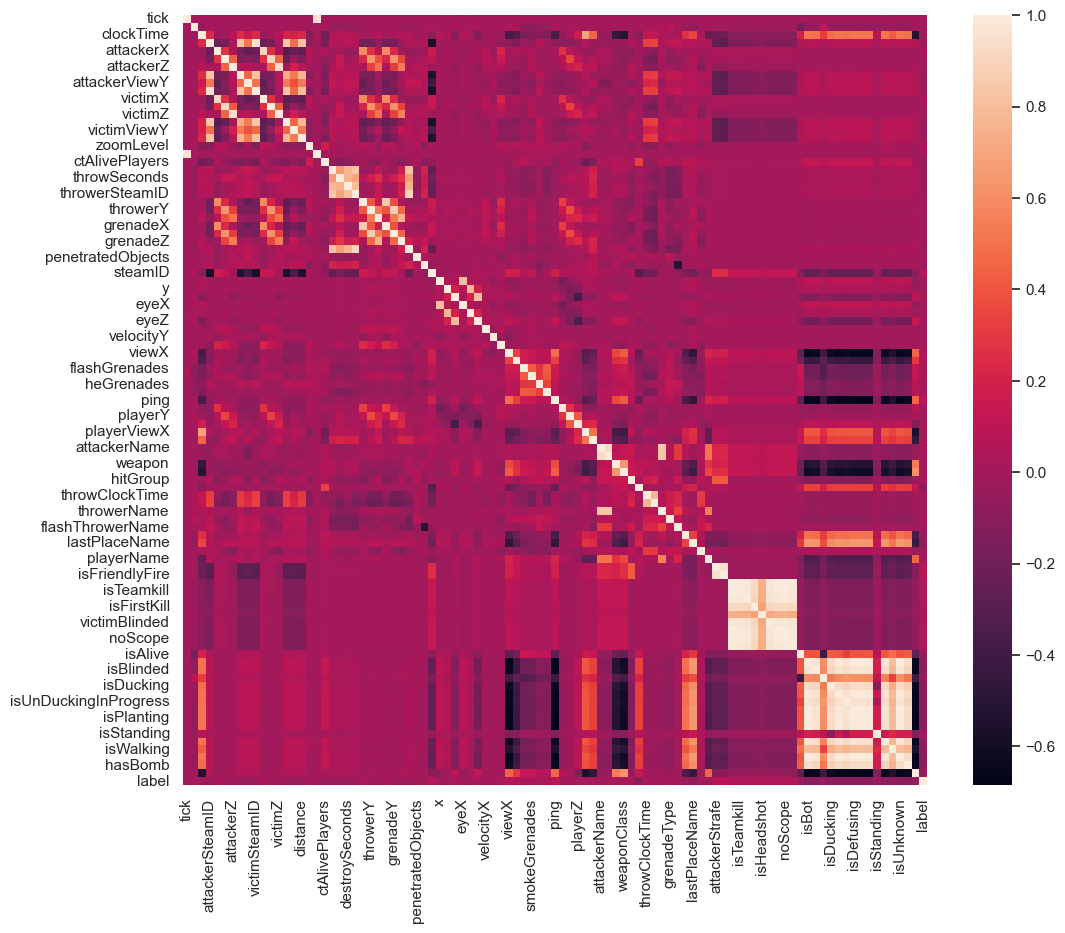

In [23]:
corr = df.corr(method='kendall')
plt.figure(figsize=(12,10))
sns.heatmap(corr)
plt.savefig('./figures/initial_correlation')
plt.show()

In [24]:
corr_col = set()
for i in range(len(df.columns)):
    for j in range(i):
        if corr.iloc[i, j] > 0.8:
            col = corr.columns[i]
            corr_col.add(col)

df = df.drop(corr_col, axis=1)

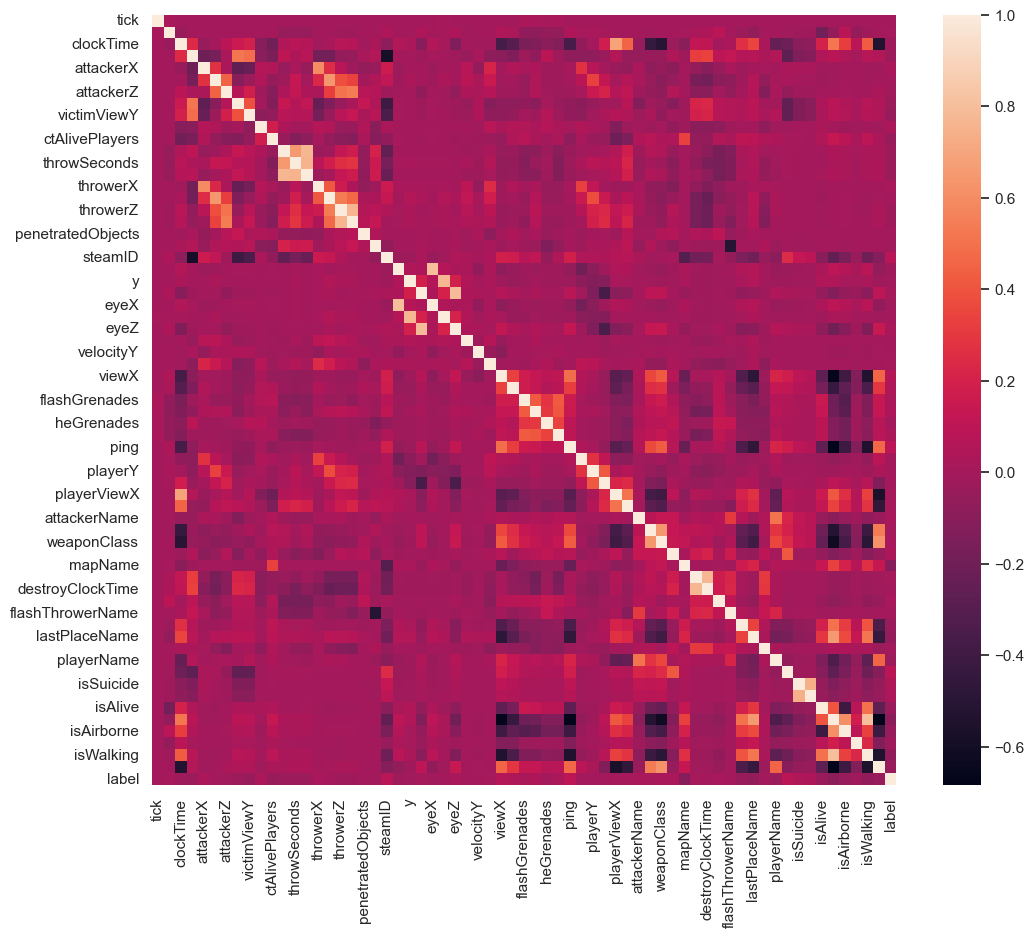

In [25]:
corr_ = df.corr(method='kendall')
plt.figure(figsize=(12,10))
sns.heatmap(corr_)
plt.savefig('./figures/fixed_correlation')
plt.show()

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670327 entries, 0 to 1670326
Data columns (total 65 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   tick                 1670327 non-null  float64
 1   seconds              1670327 non-null  float64
 2   clockTime            1670327 non-null  float64
 3   attackerSteamID      1670327 non-null  float64
 4   attackerX            1670327 non-null  float64
 5   attackerY            1670327 non-null  float64
 6   attackerZ            1670327 non-null  float64
 7   attackerViewY        1670327 non-null  float64
 8   victimViewY          1670327 non-null  float64
 9   zoomLevel            1670327 non-null  float64
 10  ctAlivePlayers       1670327 non-null  float64
 11  destroyTick          1670327 non-null  float64
 12  throwSeconds         1670327 non-null  float64
 13  destroySeconds       1670327 non-null  float64
 14  throwerX             1670327 non-null  float64
 15

Finally, we will check if any columns can be converted from *'float64'* to *'int64'* data type, perform the conversion, and save the file.

In [27]:
for column in df.columns:
    if df[column].apply(lambda x: x.is_integer() if not pd.isna(x) else True).all():
        df[column] = df[column].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670327 entries, 0 to 1670326
Data columns (total 65 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   tick                 1670327 non-null  float64
 1   seconds              1670327 non-null  float64
 2   clockTime            1670327 non-null  float64
 3   attackerSteamID      1670327 non-null  float64
 4   attackerX            1670327 non-null  float64
 5   attackerY            1670327 non-null  float64
 6   attackerZ            1670327 non-null  float64
 7   attackerViewY        1670327 non-null  float64
 8   victimViewY          1670327 non-null  float64
 9   zoomLevel            1670327 non-null  float64
 10  ctAlivePlayers       1670327 non-null  float64
 11  destroyTick          1670327 non-null  float64
 12  throwSeconds         1670327 non-null  float64
 13  destroySeconds       1670327 non-null  float64
 14  throwerX             1670327 non-null  float64
 15

In [28]:
save_dir = "D:\\anticheat\\data"
df.to_parquet(os.path.join(save_dir, 'anomalyDataset.parquet'), index=False)